In [1]:
# Librerías necesarias para el estudio
import pandas as pd
import networkx as nx 
import numpy as np
import os.path
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, chi2_contingency
from tabulate import tabulate
from itertools import combinations
from sklearn import metrics, svm, linear_model
from sklearn.model_selection import train_test_split
from neuroCombat import neuroCombat
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import Counter

# 1. Importación de datos

In [2]:
# Listado de regiones cerebrales (en su respectivo orden de aparición en las matrices de conectividad)
nodes = pd.read_csv('Datasets/mindboggle_ROIs.txt', sep='\t')["[ sROI_MINDBOGGLE]"].to_list()
num_nodes = len(nodes)
edges = [tuple(sorted(c, key=str.casefold)) for c in combinations(nodes,2) if c[0]!=[1]]

# Datos clínicos de los sujetos
clinic = pd.read_csv('Datasets/clinic.csv')

# Modificamos el datatype de la variable 'sex' para que sea categórica
clinic['sex'] = clinic['sex'].astype('category')

# Listado de identificadores de cada uno de los grupos (pacientes/controles)
patients = dict.fromkeys(clinic[clinic.controls_ms==1]['id'].to_list())
controls = dict.fromkeys(clinic[clinic.controls_ms==0]['id'].to_list())

# Matrices de conectividad de cada uno de los sujetos 
def import_connectivity_matrix(subjects):
    '''
    Dada una lista de IDs, esta función retorna
    las matrices FA, GM y rfMRI para cada uno de ellos
    en formato diccionario {ID : {FA: [], GM: [], rfMRI: []}}
    '''
    for s in subjects:
        subjects[s]               = dict.fromkeys(['FA','GM','rfMRI'])
        subjects[s]['FA']         = pd.read_csv('Datasets/subject_networks_FA_v1/'       + s +'_FA_factor.csv', header=None)
        subjects[s]['GM']         = pd.read_csv('Datasets/subject_networks_GM_v1-no-thr/'+ s +'_GM_matrix.csv', header=None)
        subjects[s]['rfMRI']      = pd.read_csv('Datasets/subject_networks_rfMRI_v1/'    + s +'_r_matrix.csv' , header=None)
        subjects[s]['zAttention'] = list(clinic[clinic.id == s]['zattention'])[0]

        
import_connectivity_matrix(patients)
import_connectivity_matrix(controls)

# 2. Preprocesamiento de datos

## 2.1. Correción por edad y sexo

In [3]:
# Calculamos el valor medio de cada variable (i,j) solo para los controles
control_means = dict.fromkeys(['FA','GM','rfMRI'])

for t in ['FA','GM','rfMRI']:
    control_means[t] = {} 
    
    for i in range(0,num_nodes):
        for j in range(i+1,num_nodes): 
            
            # Calculamos, para cada variable [i,j], la media de los valores de los sujetos control (solo diagonal superior)
            control_means[t][(i,j)] = np.mean([controls[s][t][i][j] for s in controls])


# Llevamos a cabo la corrección de los valores por edad y género 
for t in ['FA','GM','rfMRI']:
    for i in range(0,num_nodes):
        for j in range(i+1,num_nodes):  
            data = []
                
            # Para cada variable (i,j), calculamos el dataset (sujeto - género - edad - valor de (i,j) en matriz t)
            for group in [controls,patients]:
                for s in group:
                    row = []
                    row.append(s)
                    row.append(list(clinic[clinic.id==s]['sex'])[0])
                    row.append(list(clinic[clinic.id==s]['age'])[0])                  
                    row.append(group[s][t][i][j])
                    data.append(row)
            data = pd.DataFrame(data, columns=['subject','sex','age','real value'])
            
            # Ajustamos los valores a una regresión lineal en función de la edad y el sexo
            data['sex'] = data['sex'].astype('category')
            regr = linear_model.LinearRegression()
            regr.fit(data[['sex','age']], data['real value'])
            data['predicted value'] = regr.predict(data[['sex','age']])
            data['control mean'] = control_means[t][(i,j)]
            data['new value'] = data['real value']-data['predicted value']+data['control mean']
            
            # Reemplazamos el valor actual por el nuevo valor
            for group in [controls,patients]:
                for s in group:
                    group[s][t][i][j]=list(data[data.subject == s]['new value'])[0]            

## 2.2. Valores nulos

## 2.3. Normalización de datos

In [4]:
'''scaler = MinMaxScaler(feature_range=(0, 1))

# Normalizamos cada una de las variables
for t in ['FA','GM','rfMRI']:
    for i in range(0,num_nodes):
        for j in range(i+1,num_nodes):  
            values = []
            for group in [controls,patients]:
                for s in group:
                    values.append(group[s][t][i][j])
                    
            new_values = scaler.fit_transform(np.array(values).reshape(-1, 1))
            k = 0
            
            for group in [controls,patients]:
                for s in group:
                    group[s][t][i][j] = new_values[k][0]
                    k=k+1
'''                    

"scaler = MinMaxScaler(feature_range=(0, 1))\n\n# Normalizamos cada una de las variables\nfor t in ['FA','GM','rfMRI']:\n    for i in range(0,num_nodes):\n        for j in range(i+1,num_nodes):  \n            values = []\n            for group in [controls,patients]:\n                for s in group:\n                    values.append(group[s][t][i][j])\n                    \n            new_values = scaler.fit_transform(np.array(values).reshape(-1, 1))\n            k = 0\n            \n            for group in [controls,patients]:\n                for s in group:\n                    group[s][t][i][j] = new_values[k][0]\n                    k=k+1\n"

## 2.4. Harmonización de pesos

In [5]:
from combat.pycombat import pycombat

for t in ['FA']:
    for i in range(0,num_nodes):
        for j in range(i+1,num_nodes):  
            data = []
                
            # Para cada variable (i,j), calculamos el dataset (sujeto - site - valor de (i,j) en matriz t)
            for group in [controls,patients]:
                for s in group:
                    row = []
                    site = 1 if 'MSVIS' in s else 2
                    row.append(s)            
                    row.append(site)        
                    row.append(group[s][t][i][j])
                    data.append(row)
            data = pd.DataFrame(data, columns=['subject','site','real value'])            

            #Harmonization step:
            batch = list(data['site'])
            data_T = pd.DataFrame(list(data['real value'])).T
            data['new value'] = pycombat(data_T,batch,mean_only=True).T
          
            # Reemplazamos el valor actual por el nuevo valor
            for group in [controls,patients]:
                for s in group:
                    group[s][t][i][j]=list(data[data.subject == s]['new value'])[0]     

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting 

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting 

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting 

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting 

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting 

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \


Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting 

## 2.5. Aplicación de umbrales y filtrado de conexiones


In [6]:
# eliminamos cualquier conectividad <0.1 (las ponemos a cero)
for group in [patients, controls]:
    for s in group:
        for matrix in ['FA','GM','rfMRI']:
            pos = len(group[s][matrix])
            for i in range(0,pos):
                for j in range(0,pos): 
                    if group[s][matrix][i][j] < 0.1:
                        group[s][matrix][i][j] = 0

In [7]:
counter = {}

# Calculamos, para cada variable, el número de sujetos controles en las que se encuentra presente
for i in range(0,pos):
    for j in range(0,pos): 
        counter[(i,j)] =0
        for s in controls:
            if controls[s]['FA'][i][j]!=0: 
                counter[(i,j)] = counter[(i,j)] + 1

# conexiones que aparecen en más del 60% de los controles
conexiones = [c for c in counter if counter[c]/len(controls)>=0.6]
print(len(conexiones))

# Eliminamos aquellas que no se encuentran en el listado anterior
for group in [patients, controls]:
    for s in group:
        for matrix in ['FA','GM','rfMRI']:
            for i in range(0,pos):
                for j in range(0,pos):
                    if (i,j) not in conexiones:
                        group[s][matrix][i][j] = 0

3912


# 3. Estudio de los datos clínicos y demográficos

In [8]:
def mean_std(col,new_label,only_ms=0):
    '''
    Function that returns an array with four elements:
        - new_label
        - mean+std for patients
        - mean+std for controls (only if only_ms=0)
        - Student t-test p-value (only if only_ms=0)
    '''
    variable = [new_label]
    col_patients = clinic[clinic.controls_ms == 1][col]
        
    # [mean, std] for MS patients
    variable.append(col_patients.agg(['mean','std']).round(2).to_list())
    
    if only_ms == 0: 
        
        # [mean, std] for controls
        col_controls = clinic[clinic.controls_ms == 0][col]
        variable.append(col_controls.agg(['mean','std']).round(2).to_list())
        
        # Student t-test
        variable.append(mannwhitneyu(col_patients.to_list(),
                                  col_controls.to_list())
                        .pvalue)
    else:
        variable.append("n/a")
        variable.append("n/a")

    return variable


def count_pct(col,new_label):
    variable = [new_label]
    
    col_patients = list(clinic[clinic.controls_ms == 1][col])
    col_controls = list(clinic[clinic.controls_ms == 0][col])
        
    # [mean, std] for MS patients
    counts = Counter(col_patients)
    variable.append([counts[0],round(counts[0]/(counts[0]+counts[1]),2)])    
    
    # [mean, std] for MS controls
    counts = Counter(col_controls)
    variable.append([counts[0],round(counts[0]/(counts[0]+counts[1]),2)])  
    
    # test
    pvalue = chi2_contingency([list(Counter(col_patients).values()),
                               list(Counter(col_controls).values())])[1]
    variable.append(pvalue)
    
    return variable
    
data = []
data.append(mean_std('age','Age'))
data.append(count_pct('sex','Sex (F, %)'))
data.append(mean_std('dd','Disease duration',only_ms=1))
data.append(mean_std('zpasat','zPASAT score',only_ms=1))
data.append(mean_std('sdmtz','zSDMT score',only_ms=1))
data.append(mean_std('zattention','zAttention score',only_ms=1))


print (tabulate(data, headers=["Variable", "MS Patients", "Controls", "p-valor"]))

Variable          MS Patients     Controls      p-valor
----------------  --------------  ------------  ----------------------
Age               [47.33, 10.15]  [36.62, 9.6]  0.00017663447852410628
Sex (F, %)        [104, 0.71]     [15, 0.83]    0.39784392998317575
Disease duration  [15.96, 9.05]   n/a           n/a
zPASAT score      [-0.29, 1.33]   n/a           n/a
zSDMT score       [0.08, 1.06]    n/a           n/a
zAttention score  [-0.29, 1.04]   n/a           n/a


# 4. Cálculo de métricas de grafos

## 4.1. Transformación a grafos

In [9]:
def sym_matrix_to_graph (data, nodes):
    """
    Dada una matriz simetrica 'data' donde v[i,j] es el valor de la posición [i,j],
    se retorna un grafo con aristas [i,j], con nombre de los nodos nodes[i] y nodes[j], 
    y peso de la arista v[i,j]
    """
    # Declaramos la lista donde se almacenarán los diferentes pares de aristas y pesos
    weighted_edges = []

    # Calculamos las aristas y sus correspondientes pesos
    for i in range(0,len(data)):
        for j in range(i+1,len(data)):
            # no consideramos aristas aquellas conectividades que son 0
            if data[i][j]!=0 and pd.isna(data[i][j])==False:
                weighted_edges.append((nodes[i], nodes[j],data[i][j]))

    # Generamos el grafo correspondiente
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    
    # Retornamos el grafo
    return G


def connectivity_graphs(subjects, nodes):
    '''
    Dado un diccionario {ID : {FA: [], GM: [], rfMRI: []}}, donde los [] corresponden
    a datasets, esta función aplica sym_matrix_to_graph() function a cada dataset
    '''
    for s in subjects.keys():
        subjects[s]['FA']    = sym_matrix_to_graph(subjects[s]['FA'],nodes)
        subjects[s]['GM']    = sym_matrix_to_graph(subjects[s]['GM'],nodes)
        subjects[s]['rfMRI'] = sym_matrix_to_graph(subjects[s]['rfMRI'],nodes)
        
connectivity_graphs(patients,nodes)
connectivity_graphs(controls,nodes)

## 4.2. Métricas globales

- strength (sum of all neighboring link weights)
- transitivity (ratio of triangles to triplets in the network)
- global efficiency (average inverse shortest path length)
- assortativity (correlation coefficient between the degrees of all nodes on two opposite ends of a link)
- path length
- betweenness centrality (fraction of all shortest paths in the network that pass through a given node) 

In [10]:
def graph_global_metrics(graph_list):
    '''
    Dada una lista de grafos, esta función retorna, para cada uno de ellos las siguientes
    métricas: strength, transitivity, global efficiency, assortativity, clustering coefficient,
    betwenness centrality
    '''
    cmetrics = {}
    
    # Cálculo de métricas
    cmetrics['Strength']                         = [np.sum([w[1] for w in list(G.degree(weight='weight'))])
                                                   for G in graph_list]
    cmetrics['Transitivity']                     = [nx.transitivity(G) for G in graph_list]
    cmetrics['Global efficiency']                = [nx.global_efficiency(G,) for G in graph_list]
    cmetrics['Assortativity']                    = [nx.degree_pearson_correlation_coefficient(G,weight='weight') 
                                                   for G in graph_list]
    cmetrics['Path length']                      = [nx.average_shortest_path_length(G) for G in graph_list]
    cmetrics['Betweenness centrality']           = [np.mean(list(nx.betweenness_centrality(G,weight='weight').values())) 
                                                   for G in graph_list]
    # Retornamos los resultados
    return cmetrics


def global_metrics_summary(patients_metrics,controls_metrics, metrics):
    '''
    Retorna una tabla con el resumen de las métricas para ambos grupos de sujetos
    y el pvalor correspondiente
    '''
    data=[]
    
    for m in metrics:
        row = [m]

        patients_stats = (np.mean(patients_metrics[m]) .round(2),
                          np.std (patients_metrics[m]) .round(2))
        controls_stats = (np.mean(controls_metrics[m]) .round(2),
                          np.std (controls_metrics[m]) .round(2))
        pvalue = mannwhitneyu(patients_metrics[m], controls_metrics[m]).pvalue
        
        row.append(patients_stats)
        row.append(controls_stats)
        row.append(pvalue)
        data.append(row)
        
    return data
 

def bonferroni_correction(data):
    '''
    Aplicación de corrección de Bonferroni
    '''
    pvals = [row[3] for row in data]
    adjusted_pvals = list(multipletests(pvals, method='bonferroni',is_sorted=False,returnsorted=False)[1])

    i = 0
    for row in data:
        row[3] = adjusted_pvals[i]
        i=i+1

### 4.2.1. Conectividad estructural

In [11]:
# Listados de matrices de conectividad estructural para cada uno de los grupos
patients_FA = [patients[s]['FA'] for s in patients.keys()]
controls_FA = [controls[s]['FA'] for s in controls.keys()]

In [12]:
# Cálculo de métricas de grafos globales
patients_FA_metrics = graph_global_metrics(patients_FA)
controls_FA_metrics = graph_global_metrics(controls_FA)
cmetrics             = patients_FA_metrics.keys()

In [13]:
data = global_metrics_summary(patients_FA_metrics,controls_FA_metrics,cmetrics)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls              pvalue
----------------------  -----------------  ---------------  -----------
Strength                (1535.82, 129.67)  (1660.18, 62.2)  7.39327e-06
Transitivity            (0.75, 0.02)       (0.75, 0.01)     0.0669488
Global efficiency       (0.82, 0.01)       (0.83, 0.01)     0.0321027
Assortativity           (-0.08, 0.02)      (-0.09, 0.01)    0.105724
Path length             (1.35, 0.02)       (1.34, 0.01)     0.0325191
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)      0.577758


In [14]:
bonferroni_correction(data)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls              pvalue
----------------------  -----------------  ---------------  -----------
Strength                (1535.82, 129.67)  (1660.18, 62.2)  4.43596e-05
Transitivity            (0.75, 0.02)       (0.75, 0.01)     0.401693
Global efficiency       (0.82, 0.01)       (0.83, 0.01)     0.192616
Assortativity           (-0.08, 0.02)      (-0.09, 0.01)    0.634343
Path length             (1.35, 0.02)       (1.34, 0.01)     0.195115
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)      1


### 4.2.2. Conectividad morfológica

In [15]:
# Listados de matrices de conectividad estructural para cada uno de los grupos
patients_GM = [patients[s]['GM'] for s in patients.keys()]
controls_GM = [controls[s]['GM'] for s in controls.keys()]

In [16]:
# Cálculo de métricas de grafos globales
patients_GM_metrics = graph_global_metrics(patients_GM)
controls_GM_metrics = graph_global_metrics(controls_GM)
cmetrics             = patients_GM_metrics.keys()

In [17]:
data = global_metrics_summary(patients_GM_metrics,controls_GM_metrics,cmetrics)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients      Controls           pvalue
----------------------  ---------------  ---------------  --------
Strength                (213.68, 30.31)  (209.28, 25.09)  0.708612
Transitivity            (0.64, 0.02)     (0.64, 0.02)     0.751831
Global efficiency       (0.63, 0.01)     (0.62, 0.01)     0.498482
Assortativity           (-0.48, 0.01)    (-0.49, 0.01)    0.212541
Path length             (1.76, 0.03)     (1.77, 0.02)     0.459536
Betweenness centrality  (0.02, 0.0)      (0.02, 0.0)      0.583127


In [18]:
bonferroni_correction(data)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients      Controls           pvalue
----------------------  ---------------  ---------------  --------
Strength                (213.68, 30.31)  (209.28, 25.09)         1
Transitivity            (0.64, 0.02)     (0.64, 0.02)            1
Global efficiency       (0.63, 0.01)     (0.62, 0.01)            1
Assortativity           (-0.48, 0.01)    (-0.49, 0.01)           1
Path length             (1.76, 0.03)     (1.77, 0.02)            1
Betweenness centrality  (0.02, 0.0)      (0.02, 0.0)             1


### 4.2.3. Conectividad funcional

In [19]:
# Listados de matrices de conectividad estructural para cada uno de los grupos
patients_rfMRI = [patients[s]['rfMRI'] for s in patients.keys()]
controls_rfMRI = [controls[s]['rfMRI'] for s in controls.keys()]

In [20]:
# Cálculo de métricas de grafos globales
patients_rfMRI_metrics = graph_global_metrics(patients_rfMRI)
controls_rfMRI_metrics = graph_global_metrics(controls_rfMRI)
cmetrics                = patients_rfMRI_metrics.keys()

In [21]:
data = global_metrics_summary(patients_rfMRI_metrics,controls_rfMRI_metrics,cmetrics)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls               pvalue
----------------------  -----------------  -----------------  ----------
Strength                (1078.82, 295.59)  (1003.47, 354.47)  0.220311
Transitivity            (0.64, 0.06)       (0.63, 0.07)       0.262218
Global efficiency       (0.74, 0.04)       (0.71, 0.05)       0.0319025
Assortativity           (0.16, 0.09)       (0.2, 0.11)        0.139785
Path length             (1.54, 0.09)       (1.6, 0.12)        0.0233
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        0.00028047


In [22]:
bonferroni_correction(data)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls               pvalue
----------------------  -----------------  -----------------  ----------
Strength                (1078.82, 295.59)  (1003.47, 354.47)  1
Transitivity            (0.64, 0.06)       (0.63, 0.07)       1
Global efficiency       (0.74, 0.04)       (0.71, 0.05)       0.191415
Assortativity           (0.16, 0.09)       (0.2, 0.11)        0.838712
Path length             (1.54, 0.09)       (1.6, 0.12)        0.1398
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        0.00168282


## 4.3. Métricas locales

### 4.3.1. Nodos

- node strength 
- hubs (modes showing higher strength - above 1 standard deviation, SD, of the mean strength of all nodes in each group of participants - were considered hubs of the network)


In [23]:
def graph_local_metrics(graph_list, nodes):
    '''
    Dada una lista de grafos, esta función retorna, para cada uno de ellos las siguientes
    métricas: strength, transitivity, global efficiency, assortativity, clustering coefficient,
    betwenness centrality
    '''
    cmetrics = dict.fromkeys(nodes)

    for node in nodes:
        cmetrics[node] = {}
        cmetrics[node]['Strength']                = [G.degree(weight = 'weight')[node] if node in G.nodes else 0 for G in graph_list ]
        cmetrics[node]['Average strength']        = np.mean([G.degree(weight = 'weight')[node] if node in G.nodes else 0 for G in graph_list])
 
    # Retornamos los resultados
    return cmetrics


def node_strength_sigdif(patients_metrics, controls_metrics):   
    colors = []
    for node in nodes:
        pval = mannwhitneyu(patients_metrics[node]['Strength'], controls_metrics[node]['Strength']).pvalue
        
        if(pval<0.05):
            colors.append('red')
        else:
            colors.append('grey')
        
    return colors, len([c for c in colors if c=='red'])


def hubs(metrics):
    '''
    Nodes showing higher strength (above 1 standard deviation, SD, of the mean strength 
    of all nodes in each group of participants) were considered hubs of the network 
    '''
    all_avg_strengths = [metrics[node]['Average strength'] for node in metrics]
    global_mean1std = np.mean(all_avg_strengths)+np.std(all_avg_strengths) 

    hubs = [node for node in metrics if metrics[node]['Average strength'] >= global_mean1std ]
    
    return hubs


def edge_FA(graph_list,edge_list):
    
    FA = dict.fromkeys(edge_list)

    for edge in edge_list:
        edge_FA = []
        for G in graph_list:
            try:
                edge_FA.append(G[edge[0]][edge[1]]["weight"])
            except:
                edge_FA.append(0)

        FA[edge] = edge_FA
        
    return FA       

#### 4.3.1.1. Conectividad estructural

In [24]:
patients_FA_node_metrics = graph_local_metrics(patients_FA, nodes)
controls_FA_node_metrics = graph_local_metrics(controls_FA, nodes)

In [25]:
node_strength_sigdif(patients_FA_node_metrics, controls_FA_node_metrics)[1]

73

In [26]:
hubs(patients_FA_node_metrics)

['ctx-lh-inferiorparietal',
 'ctx-lh-precuneus',
 'ctx-lh-superiorparietal',
 'Left-Thalamus-Proper',
 'Left-Putamen',
 'Right-Thalamus-Proper',
 'Right-Putamen',
 'ctx-rh-inferiorparietal',
 'ctx-rh-precuneus',
 'ctx-rh-superiorparietal',
 'ctx-rh-insula']

In [27]:
hubs(controls_FA_node_metrics)

['ctx-lh-inferiorparietal',
 'ctx-lh-precuneus',
 'ctx-lh-superiorparietal',
 'Left-Thalamus-Proper',
 'Left-Putamen',
 'Right-Thalamus-Proper',
 'Right-Putamen',
 'ctx-rh-inferiorparietal',
 'ctx-rh-precuneus',
 'ctx-rh-superiorparietal']

#### 4.3.1.2. Conectividad morfológica

In [28]:
patients_GM_node_metrics = graph_local_metrics(patients_GM, nodes)
controls_GM_node_metrics = graph_local_metrics(controls_GM, nodes)

In [29]:
node_strength_sigdif(patients_GM_node_metrics, controls_GM_node_metrics)[1]

4

In [30]:
hubs(patients_GM_node_metrics)

['ctx-lh-middletemporal',
 'ctx-lh-precentral',
 'ctx-lh-precuneus',
 'ctx-lh-superiorfrontal',
 'ctx-lh-superiorparietal',
 'ctx-lh-superiortemporal',
 'ctx-lh-supramarginal',
 'ctx-rh-middletemporal',
 'ctx-rh-precentral',
 'ctx-rh-precuneus',
 'ctx-rh-superiorfrontal',
 'ctx-rh-superiorparietal',
 'ctx-rh-superiortemporal']

In [31]:
hubs(controls_GM_node_metrics)

['ctx-lh-middletemporal',
 'ctx-lh-precentral',
 'ctx-lh-precuneus',
 'ctx-lh-superiorfrontal',
 'ctx-lh-superiorparietal',
 'ctx-lh-superiortemporal',
 'ctx-lh-supramarginal',
 'ctx-rh-middletemporal',
 'ctx-rh-precentral',
 'ctx-rh-precuneus',
 'ctx-rh-superiorfrontal',
 'ctx-rh-superiorparietal',
 'ctx-rh-superiortemporal']

#### 4.3.1.3. Conectividad funcional

In [32]:
patients_rfMRI_node_metrics = graph_local_metrics(patients_rfMRI, nodes)
controls_rfMRI_node_metrics = graph_local_metrics(controls_rfMRI, nodes)

In [33]:
node_strength_sigdif(patients_rfMRI_node_metrics, controls_rfMRI_node_metrics)[1]

3

In [34]:
hubs(patients_rfMRI_node_metrics)

['ctx-lh-inferiorparietal',
 'ctx-lh-postcentral',
 'ctx-lh-precentral',
 'ctx-lh-precuneus',
 'ctx-lh-rostralmiddlefrontal',
 'ctx-lh-superiorfrontal',
 'ctx-lh-superiorparietal',
 'ctx-lh-superiortemporal',
 'ctx-rh-middletemporal',
 'ctx-rh-precentral',
 'ctx-rh-precuneus',
 'ctx-rh-rostralmiddlefrontal',
 'ctx-rh-superiorfrontal',
 'ctx-rh-superiorparietal']

In [35]:
hubs(controls_rfMRI_node_metrics)

['ctx-lh-caudalmiddlefrontal',
 'ctx-lh-postcentral',
 'ctx-lh-precentral',
 'ctx-lh-rostralmiddlefrontal',
 'ctx-lh-superiorfrontal',
 'ctx-lh-superiorparietal',
 'ctx-lh-superiortemporal',
 'ctx-rh-precentral',
 'ctx-rh-precuneus',
 'ctx-rh-rostralmiddlefrontal',
 'ctx-rh-superiorfrontal',
 'ctx-rh-superiorparietal']

### 4.3.2. Enlaces

In [36]:
patients_FA_edge_metric = edge_FA(patients_FA,edges)
controls_FA_edge_metric = edge_FA(controls_FA,edges)

edge_colors = {}

for edge in edges:
    pval1 = mannwhitneyu(patients_FA_edge_metric[edge], controls_FA_edge_metric[edge],alternative='less').pvalue
    pval2 = mannwhitneyu(patients_FA_edge_metric[edge], controls_FA_edge_metric[edge],alternative='greater').pvalue
    if(pval1<0.05):
        edge_colors[edge]='red'
    if(pval2<0.05):
        edge_colors[edge]='blue'
        

In [42]:
len(edge_colors)

1253

## 5. Clasificación

In [37]:
def SVM_pred (x, y):
    
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 5) # 70% training and 30% test

    #Create a svm Classifier
    clf = svm.SVC() 

    #Train the model using the training sets
    clf.fit(np.array(X_train).reshape(-1, 1), y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(np.array(X_test).reshape(-1, 1))

    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:",metrics.precision_score(y_test, y_pred))

    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:",metrics.recall_score(y_test, y_pred))

In [38]:
# Prediction based on grph transitivity
x = []
y = []

for p in patients: 
    x.append(nx.transitivity(patients[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])
    
for p in controls: 
    x.append(nx.transitivity(controls[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])   
    
SVM_pred (x, y)

Accuracy: 0.88
Precision: 0.88
Recall: 1.0


In [39]:
# Prediction based on global_efficiency
x = []
y = []

for p in patients: 
    x.append(nx.global_efficiency(patients[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])
    
for p in controls: 
    x.append(nx.global_efficiency(controls[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])    
    
SVM_pred (x, y)

Accuracy: 0.88
Precision: 0.88
Recall: 1.0


In [40]:
# Prediction based on average_shortest_path_length
x = []
y = []

for p in patients: 
    x.append(nx.average_shortest_path_length(patients[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])
    
for p in controls: 
    x.append(nx.average_shortest_path_length(controls[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])    
    
SVM_pred (x, y)

Accuracy: 0.88
Precision: 0.88
Recall: 1.0


## 6. Visualización


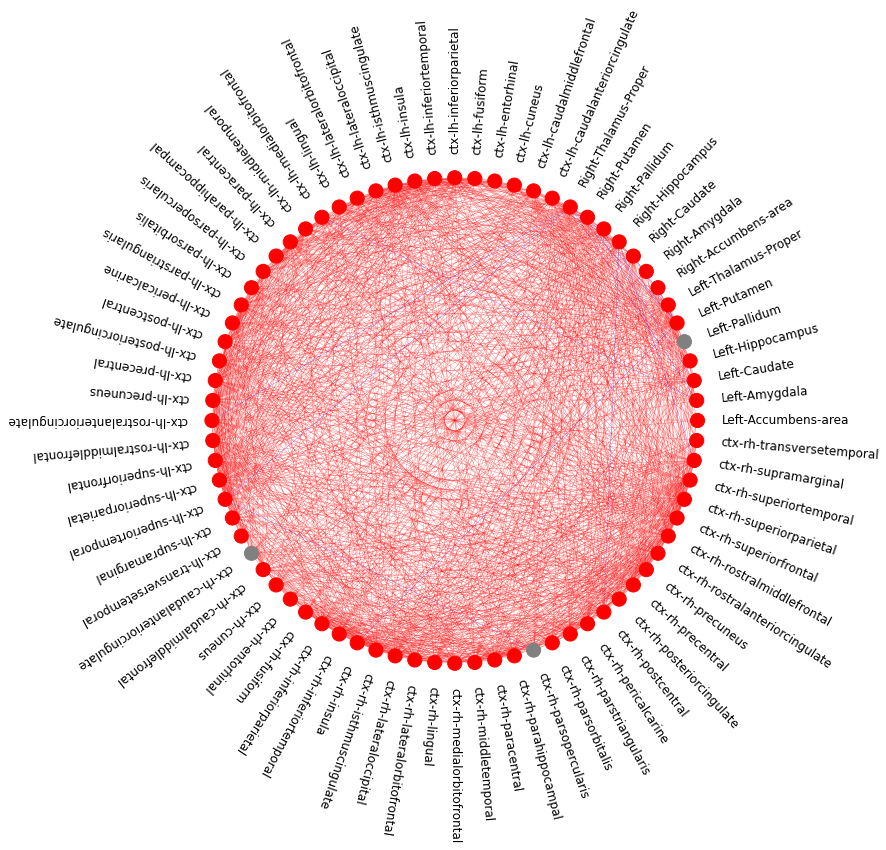

In [41]:
G=nx.Graph()
G.add_nodes_from(nodes)
node_colors = node_strength_sigdif(patients_FA_node_metrics, controls_FA_node_metrics)[0]
edges_list = edge_colors.keys()
G.add_edges_from(edges_list)
edge_colors2 = [edge_colors[(u,v)] for u,v in edge_colors]
labels={}


node_list = sorted(G.nodes())
n= len(G.nodes())
angle = []
angle_dict = {}
for i, node in zip(range(n),node_list):
    theta = 2.0*np.pi*i/n
    angle.append((np.cos(theta),np.sin(theta)))
    angle_dict[node] = theta
pos = {}
for node_i, node in enumerate(node_list):
    pos[node] = angle[node_i]

for node in G.nodes:
    labels[node]=str(node)
    
# figsize is intentionally set small to condense the graph
fig, ax = plt.subplots(figsize=(24,24))
margin=0.33
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
ax.axis('equal')

nx.draw(G,pos=pos,with_labels=False, ax=ax, node_size=200, 
        node_color = node_colors, edge_color = edge_colors2,
        width=0.2)
description = nx.draw_networkx_labels(G,pos,labels=labels)

r = fig.canvas.get_renderer()
trans = plt.gca().transData.inverted()
for node, t in description.items():
    bb = t.get_window_extent(renderer=r)
    bbdata = bb.transformed(trans)
    radius = 1.1+(bbdata.width)/2.
    position = (radius*np.cos(angle_dict[node]),radius* np.sin(angle_dict[node]))
    t.set_position(position)
    t.set_rotation(angle_dict[node]*360.0/(2.0*np.pi))
    t.set_clip_on(False)


plt.show()